## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

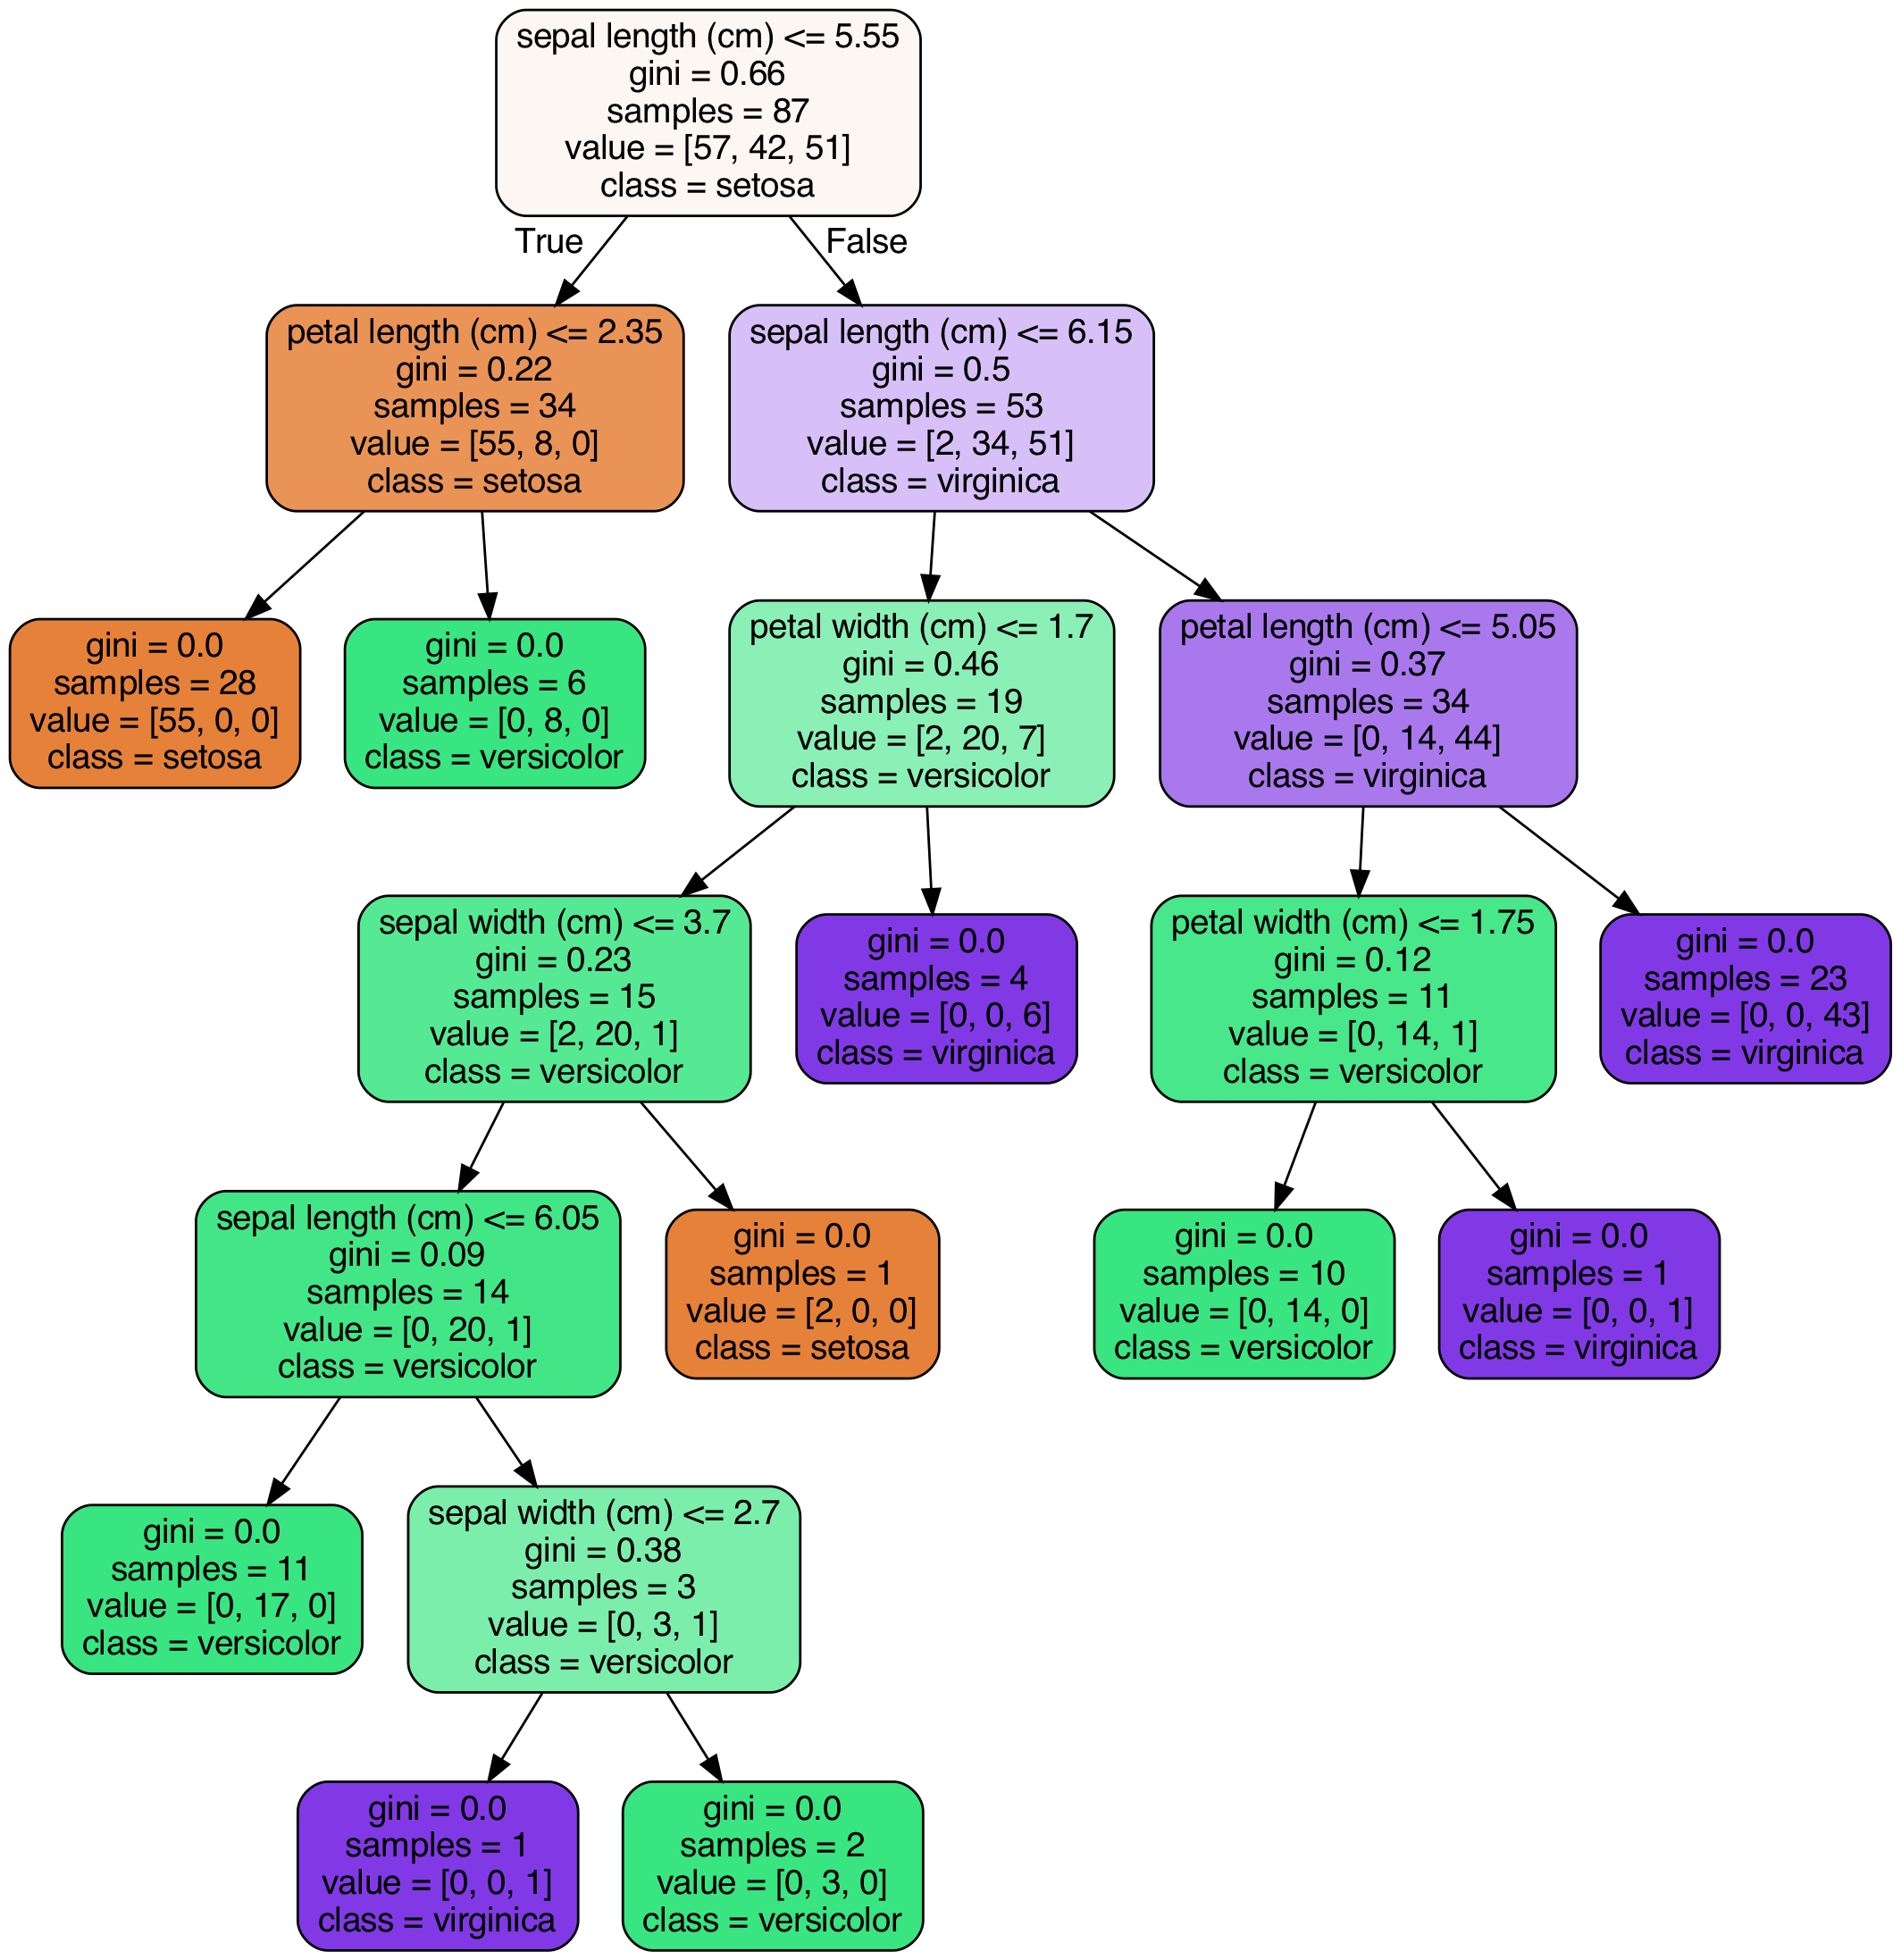

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=200'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. **The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.**

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
df = pd.read_csv('PatientInfo.csv')
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts(dropna=False)

state
isolated    1791
released     307
NaN           88
deceased      32
Name: count, dtype: int64

In [7]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state'],
      dtype='object')

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [8]:
missing_values = pd.concat([df.isna().sum().sort_values(ascending=False), 100*df.isna().mean().sort_values(ascending=False)], axis=1)
missing_values.columns = ['count', '%']
missing_values

,count,%
disease,2199,99.143372
deceased_date,2186,98.557259
infection_order,2176,98.106402
symptom_onset_date,2025,91.298467
released_date,1995,89.945897
contact_number,1807,81.469793
infected_by,1749,78.854824
infection_case,1055,47.565374
global_num,904,40.757439
birth_year,454,20.468891


 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [9]:
df.disease.unique()

array([nan, True], dtype=object)

In [10]:
df['disease'] = df['disease'].fillna(0)
df['disease'] = df['disease'].replace(True, 1)
df['disease'].unique()

array([0, 1])

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

**<font color='teal'> use mean doesn't make sense here, for example infection_order and contact_number are all interger, how to explain the infection_order and contact_number in float???**

In [11]:
# global_num use mean
df['global_num'] = df['global_num'].fillna(df['global_num'].mean())
# infection_order use median
df['infection_order'] = df['infection_order'].fillna(df['infection_order'].median())
# infected_by use mode
df['infected_by'] = df['infected_by'].fillna(df['infected_by'].mode()[0])
# contact_number use mean
df['contact_number'] = df['contact_number'].fillna(df['contact_number'].mean())

birth_year is special, maybe we can get some informnation in age.

In [12]:
((df['birth_year'].isna()) & (df['age'].isna())).sum()

151

<font color=red>age null is 261, birth_year null is 454, both null is 151.<br> 
means there are 110 rows null age but known birth year. 303 rows null birth year but known age.

<font color=red>first check null age, known birth year

In [13]:
df[(df['age'].isna()) & (df['birth_year'].notna())]['birth_year'].describe()

count     110.000000
mean     1975.127273
std        17.941346
min      1937.000000
25%      1961.250000
50%      1972.000000
75%      1987.750000
max      2018.000000
Name: birth_year, dtype: float64

In [14]:
# birth year between 1930 and 1940 is '80s' and so on
df.loc[(df['age'].isna())&(df['birth_year']>1930)&(df['birth_year']<=1940), 'age'] = '80s'
df.loc[(df['age'].isna())&(df['birth_year']>1940)&(df['birth_year']<=1950), 'age'] = '70s'
df.loc[(df['age'].isna())&(df['birth_year']>1950)&(df['birth_year']<=1960), 'age'] = '60s'
df.loc[(df['age'].isna())&(df['birth_year']>1960)&(df['birth_year']<=1970), 'age'] = '50s'
df.loc[(df['age'].isna())&(df['birth_year']>1970)&(df['birth_year']<=1980), 'age'] = '40s'
df.loc[(df['age'].isna())&(df['birth_year']>1980)&(df['birth_year']<=1990), 'age'] = '30s'
df.loc[(df['age'].isna())&(df['birth_year']>1990)&(df['birth_year']<=2000), 'age'] = '20s'
df.loc[(df['age'].isna())&(df['birth_year']>2000)&(df['birth_year']<=2010), 'age'] = '10s'
df.loc[(df['age'].isna())&(df['birth_year']>2010)&(df['birth_year']<=2020), 'age'] = '0s'

<font color=red>second check null birth year, known age

In [15]:
df[(df['birth_year'].isna()) & (df['age'].notna())]['age'].value_counts()

age
20s    79
50s    58
40s    46
30s    41
60s    34
70s    15
80s    14
10s    12
0s      3
90s     1
Name: count, dtype: int64

In [16]:
# age is '80s' with birth year 1935 and so on
df.loc[(df['birth_year'].isna())&(df['age']=='90s'), 'birth_year'] = 1925
df.loc[(df['birth_year'].isna())&(df['age']=='80s'), 'birth_year'] = 1935
df.loc[(df['birth_year'].isna())&(df['age']=='70s'), 'birth_year'] = 1945
df.loc[(df['birth_year'].isna())&(df['age']=='60s'), 'birth_year'] = 1955
df.loc[(df['birth_year'].isna())&(df['age']=='50s'), 'birth_year'] = 1965
df.loc[(df['birth_year'].isna())&(df['age']=='40s'), 'birth_year'] = 1975
df.loc[(df['birth_year'].isna())&(df['age']=='30s'), 'birth_year'] = 1985
df.loc[(df['birth_year'].isna())&(df['age']=='20s'), 'birth_year'] = 1995
df.loc[(df['birth_year'].isna())&(df['age']=='10s'), 'birth_year'] = 2005
df.loc[(df['birth_year'].isna())&(df['age']=='0s'), 'birth_year'] = 2015

<font color=red>finally check null birth year, null age

In [17]:
df[(df['birth_year'].isna()) & (df['age'].isna())].shape

(151, 18)

In [18]:
df['birth_year'].mean(), df['birth_year'].median()   

(1975.062893081761, 1975.0)

<font color=red >we use median 1975 to fillna, and so the age should be 40s

In [19]:
df['birth_year'] = df['birth_year'].fillna(1975)
df['age'] = df['age'].fillna('40s')

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [20]:
# now, can calculate the n_age
df['n_age'] = 2020 - df['birth_year']

check missing value again

In [21]:
missing_values = pd.concat([df.isna().sum().sort_values(ascending=False), 100*df.isna().mean().sort_values(ascending=False)], axis=1)
missing_values.columns = ['count', '%']
missing_values

,count,%
deceased_date,2186,98.557259
symptom_onset_date,2025,91.298467
released_date,1995,89.945897
infection_case,1055,47.565374
sex,145,6.537421
confirmed_date,141,6.357078
state,88,3.967538
city,65,2.930568
infected_by,0,0.000000
contact_number,0,0.000000


 **<font color='teal'> Fill null values in other columns for categorical variables infection_case, sex, city, we use the mode to fillna.**
 
 **<font color='teal'> fill null state as 'missing', this is what we get from the following procedures**

In [22]:
df['infection_case'] = df['infection_case'].fillna(df['infection_case'].mode()[0])
df['sex'] = df['sex'].fillna(df['sex'].mode()[0])
df['city'] = df['city'].fillna(df['city'].mode()[0])

In [23]:
df['state'] = df['state'].fillna('missing')

 **<font color='teal'> Check for any remaining null values.</font>**

In [24]:
missing_values = pd.concat([df.isna().sum().sort_values(ascending=False), 100*df.isna().mean().sort_values(ascending=False)], axis=1)
missing_values.columns = ['count', '%']
missing_values

,count,%
deceased_date,2186,98.557259
symptom_onset_date,2025,91.298467
released_date,1995,89.945897
confirmed_date,141,6.357078
patient_id,0,0.000000
infection_order,0,0.000000
state,0,0.000000
contact_number,0,0.000000
infected_by,0,0.000000
infection_case,0,0.000000


Remove date columns from the data.


In [25]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [26]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           96
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       6
infected_by         206
contact_number       73
state                 4
n_age                96
dtype: int64


Review the percent of unique values by column.

In [27]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043282
age                0.004959
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007214
infection_order    0.002705
infected_by        0.092876
contact_number     0.032913
state              0.001803
n_age              0.043282
dtype: float64


Review the range of values per column.

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.975059e+03,1.867849e+01,1.916000e+03,1.963000e+03,1.975000e+03,1.992000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.005410e+00,1.750508e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00
infected_by,2218.0,2.127038e+09,7.622108e+08,1.000000e+09,2.000000e+09,2.000000e+09,2.000000e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.494139e+01,1.867849e+01,0.000000e+00,2.800000e+01,4.500000e+01,5.700000e+01,1.040000e+02


infected_by is the patient_id, who cause other people infected. 

In [29]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.000000e+09,75.0,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.000000e+09,31.0,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.000000e+09,9.0,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,28.0


### Check for duplicated rows

In [30]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [31]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape

(2218, 7)

In [32]:
dfo.head()

,sex,age,country,province,city,infection_case,state
0,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,released
1,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,released
2,male,50s,Korea,Seoul,Jongno-gu,contact with patient,released
3,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,released
4,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,released


In [33]:
#get number of uniques for all variables
vn = pd.DataFrame(dfo.nunique(dropna=False)).reset_index()       
vn.columns = ['VarName', 'Unique_Count']
vn = vn.sort_values(by='Unique_Count', ascending =False)
vn

,VarName,Unique_Count
4,city,134
3,province,17
5,infection_case,16
1,age,11
2,country,4
6,state,4
0,sex,2


**<font color='teal'> Plot the correlation heat map for the features.</font>**

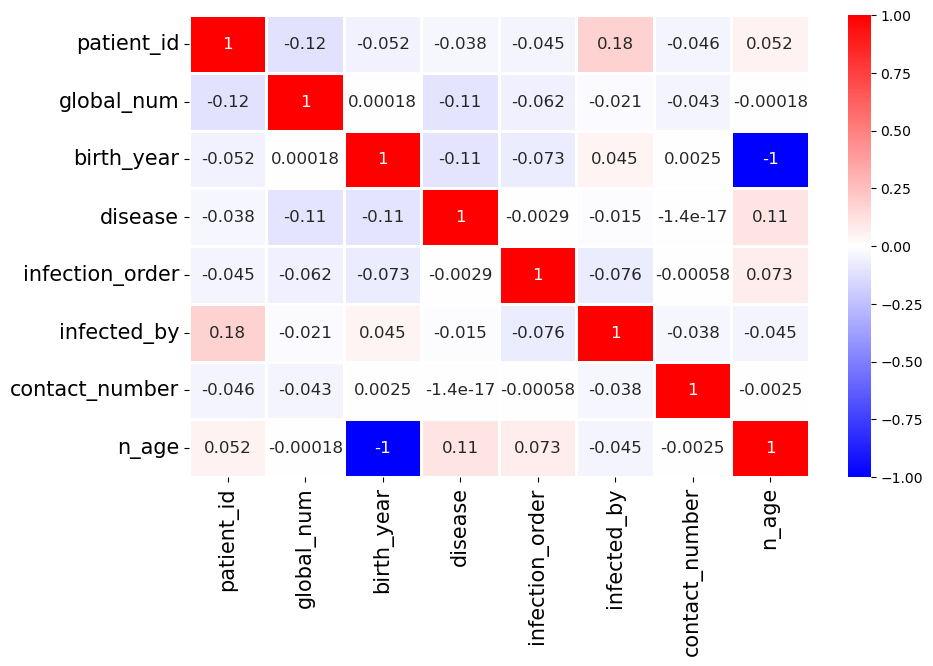

In [34]:
_ = plt.subplots(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="bwr", linewidths=1, annot_kws={"fontsize":12})
_ = plt.xticks(fontsize=15)
_ = plt.yticks(fontsize=15)
plt.show()

<font color=red> looks almost no correlation between continuous variables

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [35]:
df.nunique()

patient_id         2218
global_num         1304
sex                   2
birth_year           96
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       6
infected_by         206
contact_number       73
state                 4
n_age                96
dtype: int64

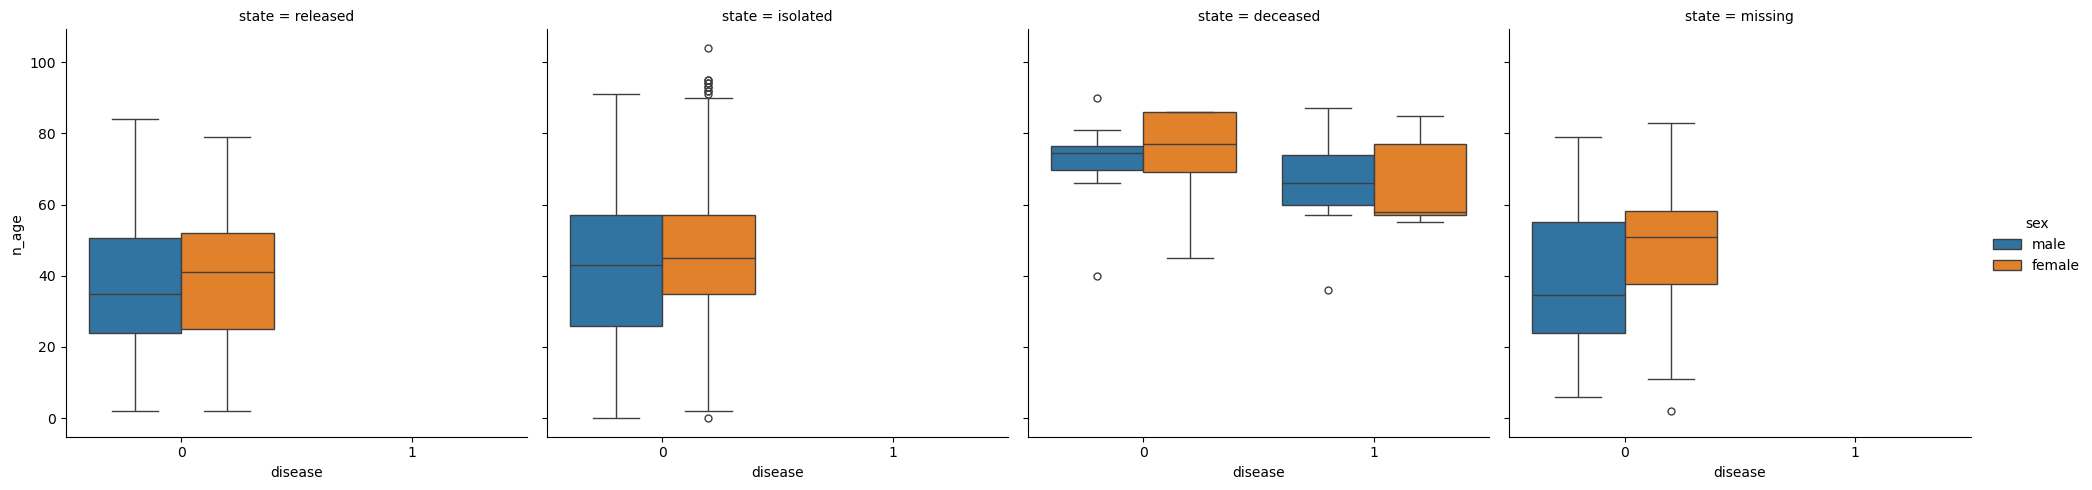

In [36]:
sns.catplot(x='disease', y='n_age', data=df, hue='sex', col='state', kind='box')

<font color=red> 1. released and isolated are all non-infected with disease=0 regardless of sex.<br>
2. some of deceased people are infected, some not, regardless of sex.<br>
3. released female have similar age distribution as male.<br>
4. isolated female have narrower IQR of age with more outliers compared with male, but similar median.<br>
5. deceased non-infected female have wider IQR of age and no outliers compared with male.<br>
6. deceased infected female have similar age distribution as male but have lower median.<br>
7. regardless of infected or not, the youngest deceased male is only 30s and female is 40s.<br>
8. the null state patient have very similar age distribution as released one. 


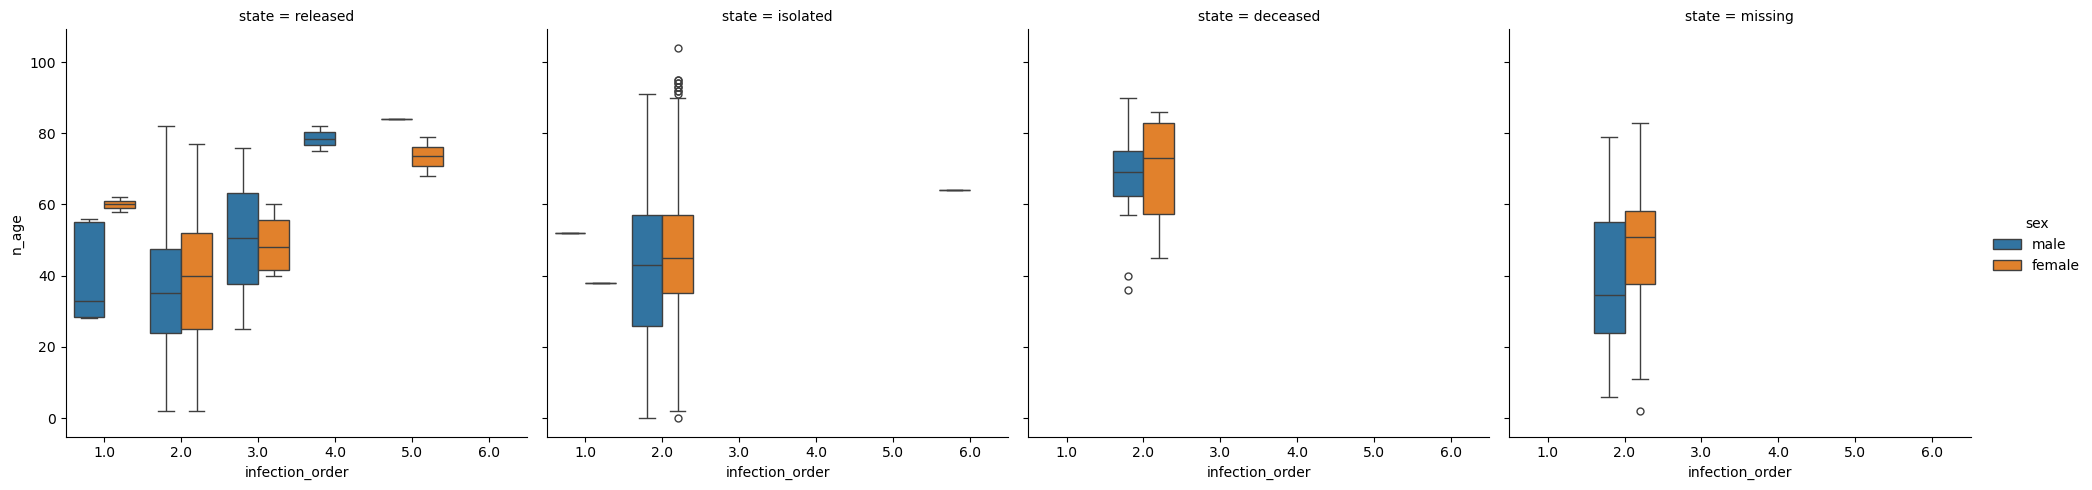

In [37]:
sns.catplot(x='infection_order', y='n_age', hue='sex', data=df, col='state', kind='box')

<font color=red> the infection order of released people are range wider and the older people are infected with high order 4 and 5. this make sense, because older people may not have too much social activity.<br>
almost all isolated people are infected in 2 order, regardless of sex<br>
all deceased people are infected in 2 order, regardless of sex.<br>

why the released female with 1 order infection have much high median age than male???? maybe just special case??

**<font color='teal'> Create dummy features for object type features. </font>**

In [38]:
X = df.drop('state', axis=1)
y = df['state']

In [39]:
X = pd.get_dummies(X)

### Split the data into test and train subsamples

In [40]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [41]:
X_train.shape, X_test.shape

((1774, 192), (444, 192))

### Scale data to prep for model creation

In [42]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

<font color=red> ridiculous operation to scale with dummy variables!!!!

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [44]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.856
Random Forest: f1-score=0.825


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [45]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   1   0   0]
 [  0 343   0   8]
 [  0   1  16   0]
 [  0  54   0  15]]


Normalized confusion matrix
[[0.86 0.14 0.   0.  ]
 [0.   0.98 0.   0.02]
 [0.   0.06 0.94 0.  ]
 [0.   0.78 0.   0.22]]


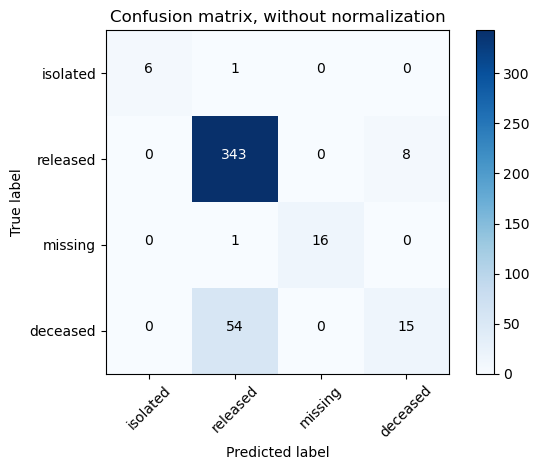

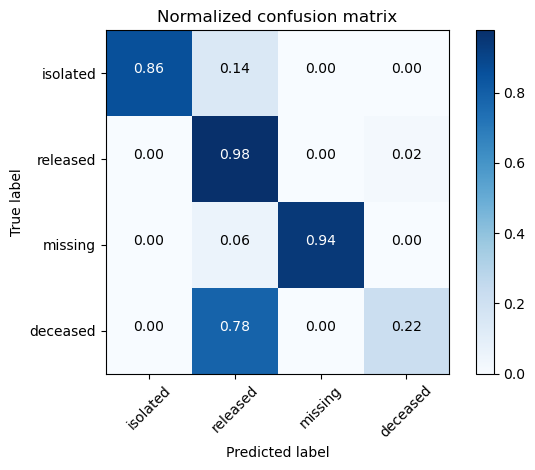

In [46]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


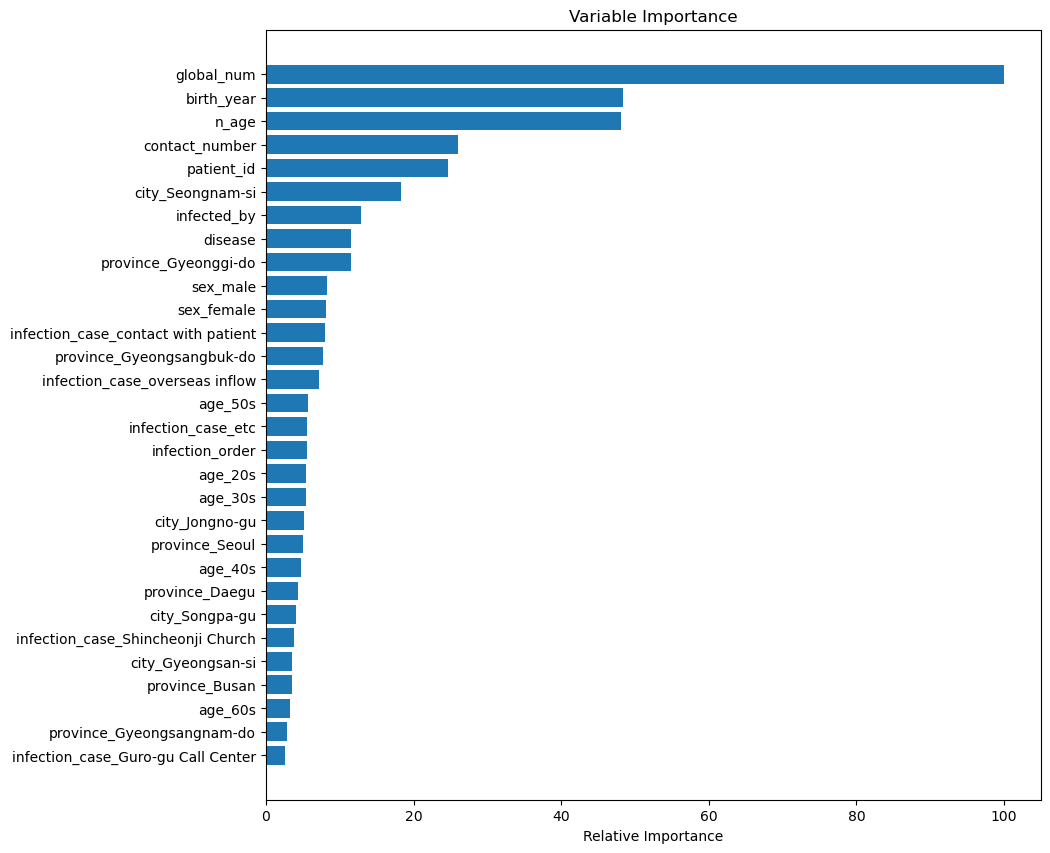

In [73]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-30:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.